#### Used to test .py files

In [ ]:
#!python predict.py

#### Downloade the dataset

In [14]:
#!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
#!tar zxvf EnglishFnt.tgz

#### Importing libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from random import shuffle
from matplotlib.patches import Rectangle


#### Reading image and applying threshold to binarize image

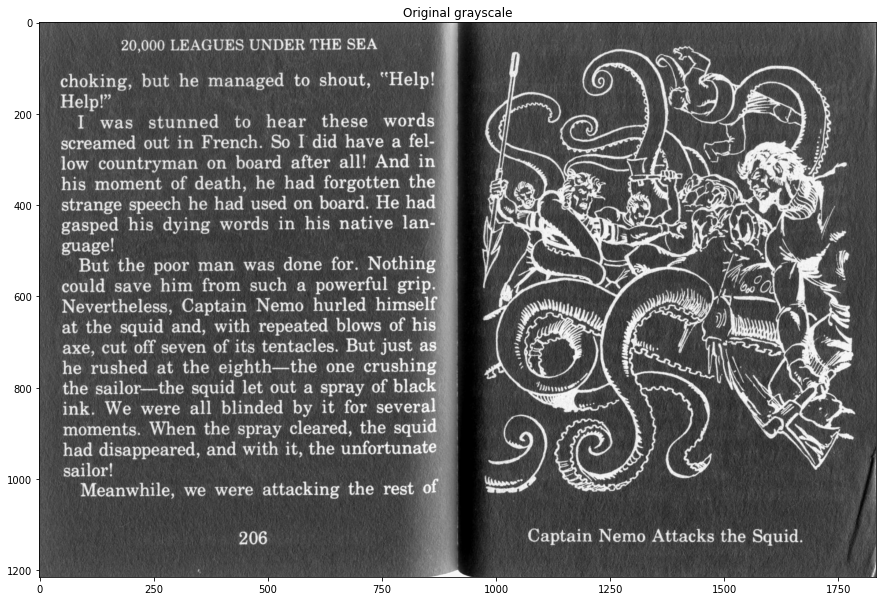

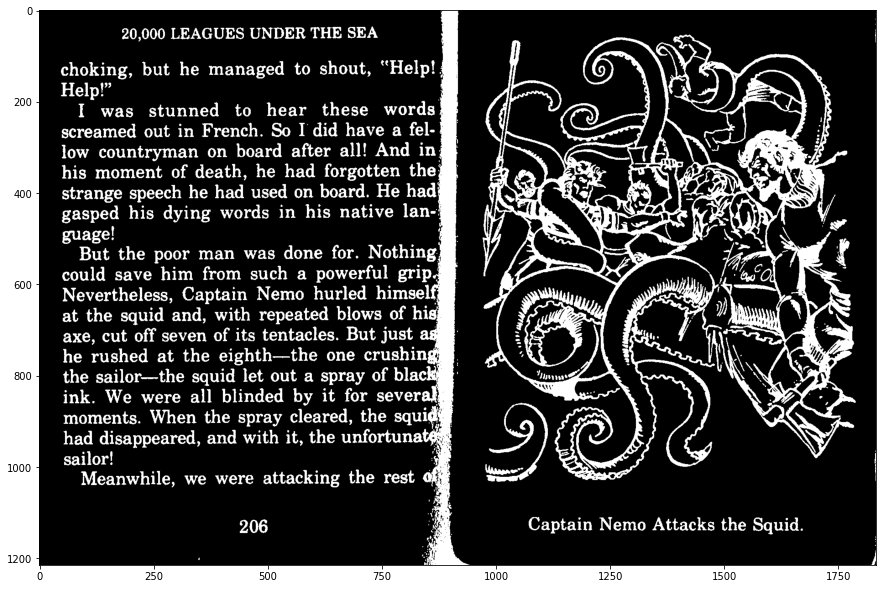

In [3]:
img=cv2.imread('20000-leagues-006-2.jpg',0)
img=255-img
plt.figure(figsize=(15,15))
plt.title('Original grayscale')
plt.imshow(img,cmap='gray')
plt.show()
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
kernel = np.ones((2,2),np.uint8)
img = cv2.erode(img,kernel,iterations = 1)
img= cv2.dilate(img,kernel,iterations = 1)

plt.figure(figsize=(15,15))

plt.imshow(img,cmap='gray')
plt.show()

#### Applying the connected components to extract characters statistics

In [4]:
num_labels, labels_im,stats,centroids = cv2.connectedComponentsWithStats(img,connectivity=4)

label_hue = np.uint8(254*labels_im/np.max(labels_im))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

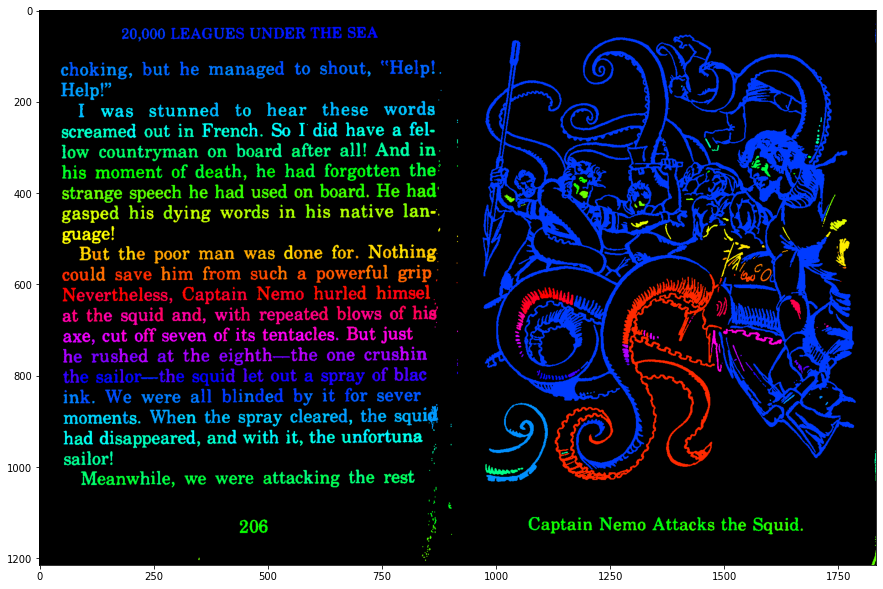

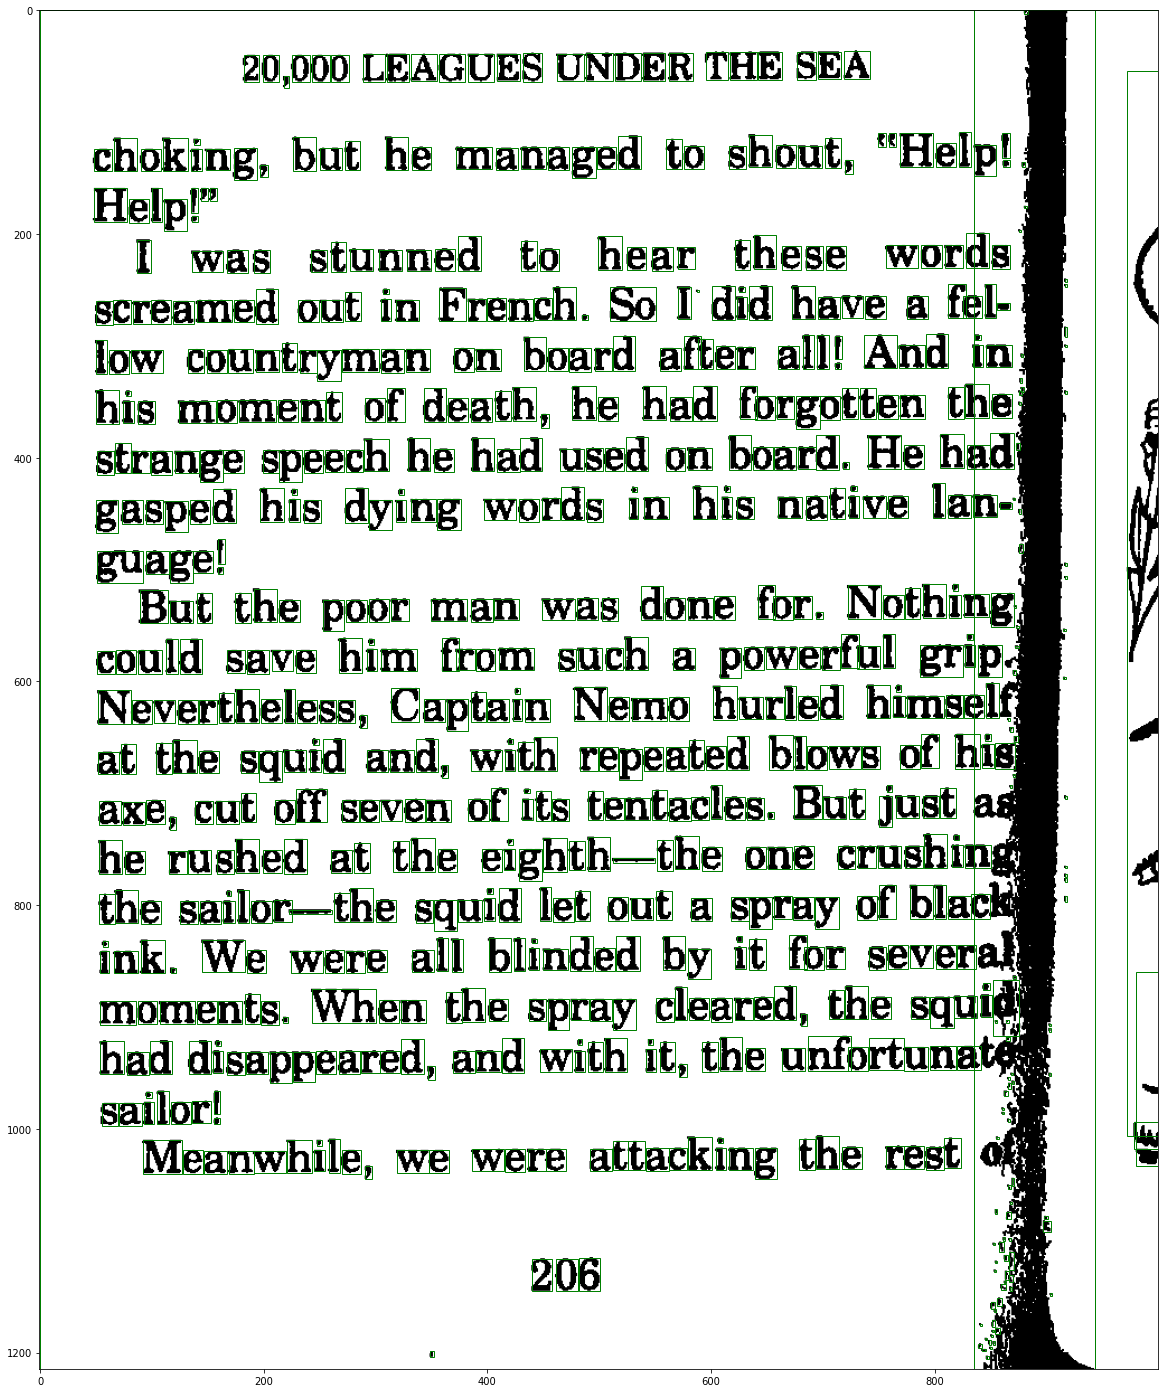

In [5]:
plt.figure(figsize=(15,15))

plt.imshow(labeled_img)
plt.show()
plt.figure(figsize=(25,25))
plt.imshow(255-img[:,:1000],cmap='gray')
# Add the patch to the Axes
for i in range(stats.shape[0]):
  plt.gca().add_patch(Rectangle((stats[i,0],stats[i,1]),stats[i,2],stats[i,3],linewidth=1,edgecolor='g',facecolor='none'))
plt.show()

#### Plotting a sample character

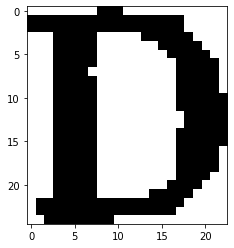

In [6]:
ind=13
temp=img[stats[ind,1]:stats[ind,1]+stats[ind,3],stats[ind,0]:stats[ind,0]+stats[ind,2]]
plt.imshow(255-temp,cmap='gray')
plt.show()

#### Reading the dataset and creating arrays for model training

In [7]:
folders=glob('English/Fnt/*')
files=[]
for folder in folders:
  files=files+glob(folder+'/*.png')

In [8]:
X=np.zeros((len(files),1,20,20))
y=np.zeros(len(files)).astype('int')
for i in range(len(files)):
  temp_img=cv2.imread(files[i],0)
  y[i]=int(files[i].split('/')[3].split('-')[0][3:])-1
  temp_img=cv2.resize(temp_img,(20,20))
  temp_img = cv2.threshold(temp_img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
  X[i,0,:,:]=255-np.copy(temp_img)

In [9]:
X=X/X.max()
X.max()

1.0

In [10]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2)

In [11]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(50393, 1, 20, 20)
(12599, 1, 20, 20)
(50393,)
(12599,)


#### Torch model : 2 Conv , 3 fc layers

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*2*2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(np.unique(ytrain)))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)
temp=torch.randn(2,1,20,20).to(device)
net(temp).size()

torch.Size([2, 62])

In [14]:
epochs=50
batch_size=32
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

#### Model training

In [15]:
prev_val_acc=0
for epoch in range(epochs):
    running_loss = 0.0
    rand_ids=np.arange(Xtrain.shape[0])
    shuffle(rand_ids)
    Xtrain=Xtrain[rand_ids]
    ytrain=ytrain[rand_ids]
    for i in range(int(Xtrain.shape[0]/batch_size)):
        
        inputs=torch.from_numpy(Xtrain[i*batch_size:(i+1)*batch_size]).float()
        labels=torch.from_numpy(ytrain[i*batch_size:(i+1)*batch_size])
        inputs=inputs.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

            inputs=torch.from_numpy(Xtrain).float()
            inputs=inputs.to(device)
            outputs=net(inputs)
            outputs=np.argmax(outputs.detach().cpu().numpy(),axis=1)
            print('Train accuracy:',100*(outputs==ytrain).sum()/ytrain.shape[0])


            inputs=torch.from_numpy(Xtest).float()
            inputs=inputs.to(device)
            outputs=net(inputs)
            outputs=np.argmax(outputs.detach().cpu().numpy(),axis=1)
            current_acc=100*(outputs==ytest).sum()/ytest.shape[0]
            print('Validation accuracy:',current_acc)
            if current_acc>prev_val_acc:
              torch.save(net,'net.pt')
            prev_val_acc=current_acc

[1,  1000] loss: 0.687
Train accuracy: 75.46484630801898
Validation accuracy: 74.58528454639257
[2,  1000] loss: 0.313
Train accuracy: 80.76518564086282
Validation accuracy: 79.28407016429875
[3,  1000] loss: 0.260
Train accuracy: 82.9004028337269
Validation accuracy: 81.59377728391142
[4,  1000] loss: 0.224
Train accuracy: 85.19437223423888
Validation accuracy: 82.3319311056433
[5,  1000] loss: 0.197
Train accuracy: 86.69458059651141
Validation accuracy: 83.29232478768157
[6,  1000] loss: 0.177
Train accuracy: 88.25432103665192
Validation accuracy: 84.58607826017938
[7,  1000] loss: 0.161
Train accuracy: 88.80400055563273
Validation accuracy: 84.41146122708152
[8,  1000] loss: 0.145
Train accuracy: 89.52830750302621
Validation accuracy: 84.44320977855385
[9,  1000] loss: 0.136
Train accuracy: 90.17522274919136
Validation accuracy: 84.62576394951981
[10,  1000] loss: 0.126
Train accuracy: 90.75069950191495
Validation accuracy: 84.93531232637511
[11,  1000] loss: 0.116
Train accuracy: 9

#### Loading the model with best validation accuracy

In [16]:
net=torch.load('net.pt')

#### Lookup array for all characters

In [17]:
lookup_arr=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M',
            'N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','c','d','e','f','g','h','i','j',
            'k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

#### Min and Max area
Our connected components can contain noise. so here we are removing the outliers by taking the values around the mean . We select minimum and maximum area a character might have

In [19]:
min_val=stats[1:,4].mean()-4*np.sqrt(stats[1:,4].std())
max_val=stats[1:,4].mean()+4*np.sqrt(stats[1:,4].std())

#### Possible rows in the document
 Next, we can compute the possible rows in our document. For this all the bounding boxes are summed over the row axis. This gives us a histogram-like vector . we suppress the noise by placing 0 where row-wise sum is less than 5 .

 Next we compute the edges. This will identify which character lie in which line of the document 

In [20]:
row_vals=np.zeros(img.shape[0])
for i in range(stats.shape[0]):
  if stats[i,4]>min_val and stats[i,4]<max_val:
    for j in range(int(stats[i,3])):
      row_vals[int(stats[i,1])+j]=row_vals[int(stats[i,1])+j]+1
row_vals[row_vals<5]=0
edges=[]
for i in range(2,row_vals.shape[0]):
  if row_vals[i]==0 and not(row_vals[i-1]==0):
    edges.append(i-1+5)
  if row_vals[i-1]==0 and not(row_vals[i]==0):
    edges.append(i-10)

#### Possible rows rotated by 90 degrees for plotting purposes

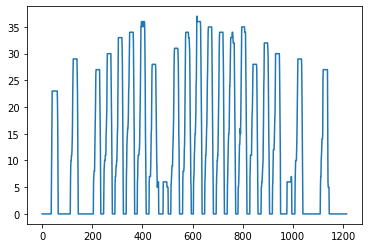

44


In [21]:
plt.plot(row_vals)
plt.show()
print('Number of edges',len(edges))

#### Predictions 
Predictions are made on all characters. Next these are sorted with their column values to identify their position in the word and sentences.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


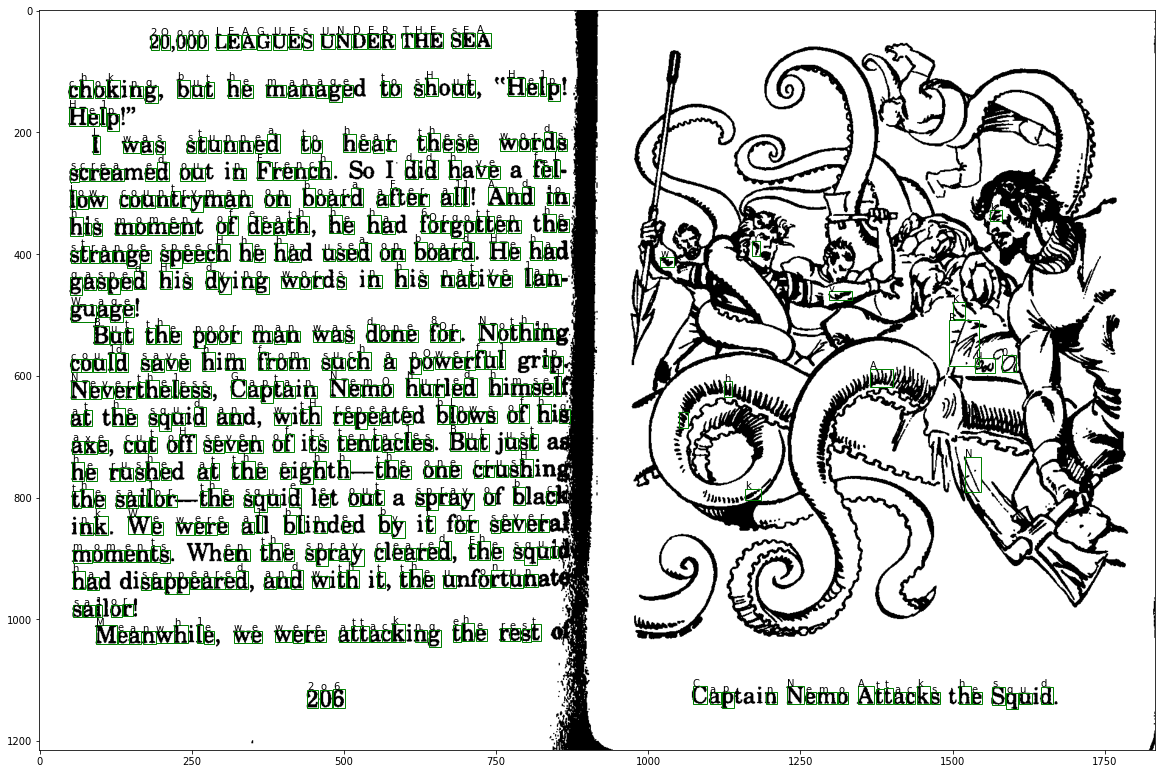

In [22]:
text_poses=[]
new_stats=np.copy(stats)
plt.figure(figsize=(20,20))
plt.imshow(255-img,cmap='gray')
pred_arr=np.zeros(stats.shape[0])
for i in range(1,stats.shape[0]):
    temp=img[stats[i,1]:stats[i,1]+stats[i,3],stats[i,0]:stats[i,0]+stats[i,2]]
    temp=cv2.resize(temp,(16,16))
    new_temp=np.zeros((20,20))
    new_temp[2:18,2:18]=np.copy(temp)
    temp=np.copy(new_temp)


    temp=temp/temp.max()

    pred=net(torch.from_numpy(temp).unsqueeze(0).unsqueeze(0).to(device).float()).detach().cpu().numpy()
    pred_class=np.argmax(pred,axis=1)

    pred_score=np.max(pred)
    if stats[i,4]>min_val and stats[i,4]<max_val and np.log(pred_score)>0:

      x_val= stats[i,1]

      if len(np.where(edges<x_val)[0])==0:
        x_val_ind=0
      else:
        x_val_ind=np.where(edges<x_val)[0][-1]+1

      text_poses.append([1+ x_val_ind,stats[i,0],stats[i,1],stats[i,2],stats[i,3],int(pred_class)])
      plt.gca().add_patch(Rectangle((stats[i,0],stats[i,1]),stats[i,2],stats[i,3],linewidth=1,edgecolor='g',facecolor='none'))
      plt.text(stats[i,0], stats[i,1],lookup_arr[int(pred_class)] )
plt.show()

#### Printing the text
Finally we have row positions of each character and its position in the respective row. Lets print the lines. 

We can print a blank space if we find that a character is far from its previous character so we should place a blank first before printing the character

In [23]:
text_poses=np.array(text_poses)
for row in np.unique(text_poses[:,0]):
  line=''
  row_poses=text_poses[text_poses[:,0]==row]
  row_poses=row_poses[row_poses[:,1].argsort()]
  prev_point=row_poses[0,1]
  for j in range(row_poses.shape[0]):
    if (row_poses[j,1]-prev_point)>10:
      line=line+' '

    line=line+lookup_arr[row_poses[j,5]]
    prev_point=row_poses[j,1]+row_poses[j,3]
  print(line)

2O ooo LEAGUEs UNDER THE sEA
chok ng but he manage to sH ut He1p
He1p
I was stunnea to hear these words
screa ed ou n French d d h ve feL
iow countryman on boara aF er a11 And 1o
h1s momen of eeath he ha 6Orgotten he k
strange speecH he ha usea on board He ha w Y
gasped H s dy ng wor s n h s nat ve 1an v
Wage K
But the poor man was done 8Or Noth1n R
cou1d save h m from such a pOwerfu1 1p A u 0
Neverthe1ess Gapta n NemO hur ed h mse1 h
at he squ d an w tH repea e bLows of h g Y
axe cut oH seven of ts tentac1es But ust
he rushe at the e gh h the one crusH N
the sa11or the squ e e out spray o b c k
nk We were a1 b1 n e by t or sever
moments en the spray c eared Ehe squ1
ha seppeared and w th t the u onun
sa1 or
Meanwh 1e we were attack ng ehe rest
2o6 Cap n Nemo Attacks he squ d
